In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, recall_score

In [39]:
def run_test(pretrain_mode = 'ConPro', mode = 0, epo = 0):
    pretrain_mode = pretrain_mode

    data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
    image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
                for x in ['test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
    class_names = image_datasets['test'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # print(device, class_names)

    bestmodel = models.resnet50(weights='ResNet50_Weights.DEFAULT')#get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')
    bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                    torch.nn.ReLU(),
                                    torch.nn.Dropout(0.1),
                                    torch.nn.Linear(1000, 256),
                                    torch.nn.ReLU(),
                                    torch.nn.Dropout(0.1),
                                    torch.nn.Linear(256, len(class_names)))
    bestmodel.load_state_dict(torch.load(f'./pretrained/{pretrain_mode}/best{mode}-{pretrain_mode}-{epo}.pt'))
    bestmodel.to(device)

    test_acc = 0
    predlist = []
    labelist = []
    problist = []
    sedis = 0
    mae = 0
    for inputs, labels in dataloaders['test']:
        bestmodel.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = bestmodel(inputs)
            # emb = fextractor(inputs)
            _, preds = torch.max(outputs, 1)
            # loss = loss_fn(outputs, labels)
            sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
            mae = mae + torch.sum((torch.abs(labels - torch.max(outputs, 1)[1])))
        problist.append(outputs[:,1].detach().cpu().numpy())
        labelist.append(labels.detach().cpu().numpy()*1)
        predlist.append(preds.detach().cpu().numpy())
        # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
        test_acc += torch.sum(preds == labels.data)

    labelist = np.concatenate(labelist).ravel()
    problist = np.concatenate(problist).ravel()
    predlist = np.concatenate(predlist).ravel()
    return sedis/dataset_sizes['test'], recall_score(labelist, predlist, average='macro'), f1_score(labelist, predlist, average='macro'), mae/dataset_sizes['test'], labelist, problist, predlist, class_names
    # # print('MAEE', sedis/dataset_sizes['test'])
    # # print('weight F1', f1_score(labelist, predlist, average='weighted'))
    # # print('macro F1', f1_score(labelist, predlist, average='macro'))
    # # print(classification_report(labelist, predlist, digits=3))

Run # 2


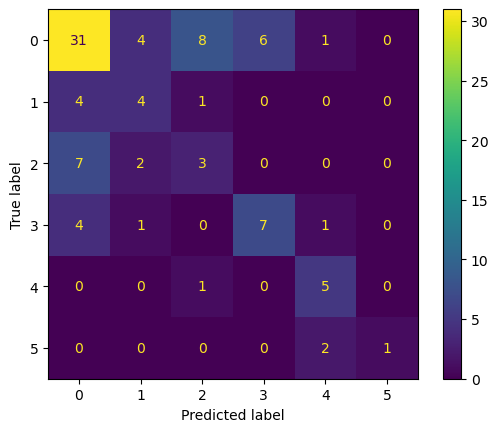

In [108]:
maeelist = []
reclist = []
mf1list = []
pretrain_model = 'ConPro'
for i in range(2,3):
    print('Run #',i)
    # maee, _, _ = run_test(pretrain_model, 'f1', i)
    # _, acc, _ = run_test(pretrain_model, 'f1', i)
    # _, _, mf1 = run_test(pretrain_model, 'f1', i)
    maee, rec, mf1, mae, labelist, problist, predlist, class_names = run_test(pretrain_model, 'f1', i)
    # print('MAEE', maee)
    # print('Precision', acc)
    # print('macro F1', mf1)
    maeelist.append(maee)
    mf1list.append(mf1)
    reclist.append(rec)

    cm = confusion_matrix(labelist, predlist)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()


In [105]:
print('mean and std of F1', np.mean(mf1list)*100, np.std(mf1list)*100)
print('mean and std of recall', np.mean(reclist)*100, np.std(reclist)*100)
print('mean and std of maee', np.mean(torch.stack(maeelist).cpu().numpy()), np.std(torch.stack(maeelist).cpu().numpy()))
print('mean and std of mae', np.mean(mae.cpu().numpy()), np.std(mae.cpu().numpy()))

mean and std of F1 52.07766845139648 0.0
mean and std of recall 53.56695156695157 0.0
mean and std of maee 4.953766 0.0
mean and std of mae 0.827957 0.0


In [ ]:
3
mean and std of F1 49.84935897435898 0.0
mean and std of recall 50.326210826210826 0.0
mean and std of maee 5.2437763 0.0
mean and std of mae 0.86021507 0.0
2
mean and std of F1 49.84935897435898 0.0
mean and std of recall 50.326210826210826 0.0
mean and std of maee 5.0550904 0.0
mean and std of mae 0.8817204 0.0

In [ ]:
mean and std of maee 5.43899 0.0
mean and std of mae 0.9677419 0.0

In [ ]:
ConPro
mean and std of maee 4.7546277 0.0
mean and std of mae 0.8494624 0.0
SimCLR
mean and std of maee 4.687684 0.0
mean and std of mae 0.8924731 0.0

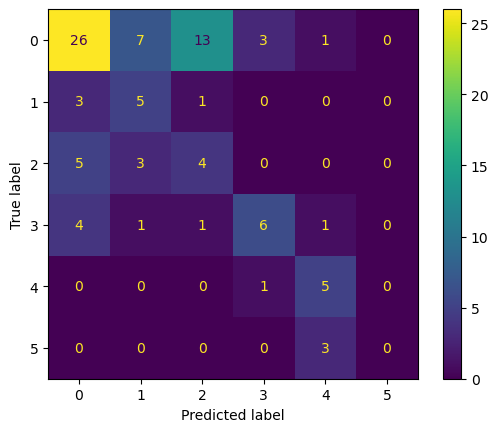

In [85]:
#SimCLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

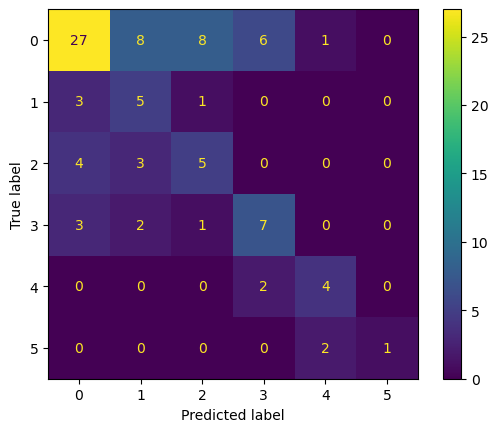

In [75]:
#ConPro
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [24]:
maeelist

[tensor(5.2205, device='cuda:0'),
 tensor(4.7053, device='cuda:0'),
 tensor(4.7731, device='cuda:0'),
 tensor(5.4390, device='cuda:0'),
 tensor(4.8788, device='cuda:0'),
 tensor(4.5318, device='cuda:0'),
 tensor(4.7246, device='cuda:0'),
 tensor(4.8233, device='cuda:0'),
 tensor(4.5711, device='cuda:0'),
 tensor(4.6683, device='cuda:0'),
 tensor(4.6877, device='cuda:0'),
 tensor(5.1466, device='cuda:0'),
 tensor(4.7414, device='cuda:0'),
 tensor(4.4120, device='cuda:0'),
 tensor(5.0972, device='cuda:0'),
 tensor(4.9096, device='cuda:0'),
 tensor(4.4120, device='cuda:0'),
 tensor(4.6366, device='cuda:0'),
 tensor(5.0092, device='cuda:0'),
 tensor(5.2470, device='cuda:0'),
 tensor(4.6366, device='cuda:0'),
 tensor(4.7546, device='cuda:0'),
 tensor(4.8911, device='cuda:0'),
 tensor(4.3627, device='cuda:0'),
 tensor(5.0788, device='cuda:0'),
 tensor(4.9607, device='cuda:0'),
 tensor(4.5361, device='cuda:0'),
 tensor(5.1157, device='cuda:0'),
 tensor(4.8233, device='cuda:0'),
 tensor(4.7555